## Vesuvius Challenge - Ink Detection Training Notebook

### Setup

In [1]:
# # Pretrained weights
# # ref - https://github.com/kenshohara/3D-ResNets-PyTorch
# !pip install gdown
# !gdown 1Nb4abvIkkp_ydPFA9sNPT1WakoVKA8Fa

# # Utility packages for reading and visualizing volumes
# !pip install zarr imageio-ffmpeg

# save model checkpoints
!mkdir ./ckpts

In [2]:
import os
import gc
import sys
import zarr
import random
import imageio
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import Video

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda import amp
from torch.utils.data import Dataset, DataLoader

sys.path.append("./resnet3d")
from resnet3d import generate_model

### Config

In [3]:
LR = 1e-4
EPOCHS = 50
BATCH_SIZE = 32
CROP_SIZE = 256
Z_START = 24
Z_DIMS = 16
TRAIN_FRAGMENTS = ["1", "2"]
TEST_FRAGMENT = "3"

### Load data

In [4]:


FRAGMENTS_ZARR = {
    "1" : zarr.open("/home/viktor/Documents/kaggle/vesuvius-challenge/kaggle-data/train-1.zarr", mode="r"),
    "2" : zarr.open("/home/viktor/Documents/kaggle/vesuvius-challenge/kaggle-data/train-2.zarr", mode="r"),
    "3" : zarr.open("/home/viktor/Documents/kaggle/vesuvius-challenge/kaggle-data/train-3.zarr", mode="r")
}

FRAGMENTS_SHAPE = {k : v.mask.shape for k, v in FRAGMENTS_ZARR.items()}

### Visualise input

In [5]:
fragment = FRAGMENTS_ZARR["1"]
x, y = 2000, 2000

fragment_cropped = fragment.surface_volume[y:y+CROP_SIZE, x:x+CROP_SIZE, Z_START:Z_START+Z_DIMS]
imageio.mimwrite("fragment_crop.mp4", fragment_cropped.transpose(2, 0, 1), "ffmpeg")
Video("fragment_crop.mp4", height=256, width=256)

Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. C

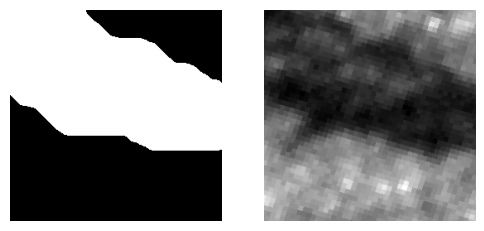

In [6]:
mask_cropped = fragment.truth[y:y+CROP_SIZE, x:x+CROP_SIZE]
ir_cropped = fragment.infrared[y:y+CROP_SIZE, x:x+CROP_SIZE]

plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.imshow(mask_cropped, cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(ir_cropped, cmap="gray")
plt.axis("off")
plt.show()

In [7]:
del fragment, fragment_cropped, mask_cropped, ir_cropped
gc.collect()

4093

### Dataloaders

In [8]:
# import albumentations as A
# from albumentations.pytorch import ToTensorV2

# class VesuviusTrain(Dataset):
#     def __init__(self, fragments):
#         self.fragments = fragments
#         self.xys = []
        
#         for fragment in fragments:
#             H, W = FRAGMENTS_SHAPE[fragment]
#             for y in range(0, H-CROP_SIZE+1, CROP_SIZE):
#                 for x in range(0, W-CROP_SIZE+1, CROP_SIZE):
#                     self.xys.append((fragment, x, y, W, H))
        
#         train_aug_list = [
#                 # A.RandomResizedCrop(
#                 #     size, size, scale=(0.85, 1.0)),
#                 A.HorizontalFlip(p=0.5),
#                 A.VerticalFlip(p=0.5),
#                 A.RandomBrightnessContrast(p=0.75),
#                 A.CoarseDropout(max_holes=1, max_width=int(CROP_SIZE * 0.1), max_height=int(size * 0.1), 
#                                 mask_fill_value=0, p=0.5),
#                 A.ShiftScaleRotate(p=0.75),
#                 A.Rotate(limit=90, p=0.9), 
#                 A.OneOf([
#                         A.GaussNoise(var_limit=[10, 50]),
#                         A.GaussianBlur(),
#                         A.MotionBlur(),
#                         ], p=0.4),
#                 A.GridDistortion(num_steps=1, distort_limit=0.3, p=0.5),
                
#                 A.Cutout(max_h_size=int(size * 0.6),
#                          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
#                 A.Normalize(
#                     mean= [0] * Z_DIMS,
#                     std= [1] * Z_DIMS
#                 ),
#                 ToTensorV2(transpose_mask=True),
#             ]
        
        
        
#     def __getitem__(self, i):
#         fragment, x1, y1, W, H = self.xys[i]
#         z1, z2 = Z_START, Z_START+Z_DIMS
        
#         x_offset = random.randint(-32 if x1 != 0 else 0, 32)
#         y_offset = random.randint(-32 if y1 != 0 else 0, 32)
        
#         x1 += x_offset
#         y1 += y_offset
        
#         x2 = x1 + CROP_SIZE
#         y2 = y1 + CROP_SIZE
        
#         if x2 > W:
#             x1 -= x_offset
#             x2 -= x_offset
            
#         if y2 > H:
#             y1 -= y_offset
#             y2 -= y_offset
        
#         frag_crop = FRAGMENTS_ZARR[fragment].surface_volume[y1:y2, x1:x2, z1:z2]
#         mask_crop = FRAGMENTS_ZARR[fragment].truth[y1:y2, x1:x2]
        
#         if random.random() > 0.5:
#             frag_crop = np.flip(frag_crop, axis=1).copy()
#             mask_crop = np.flip(mask_crop, axis=1).copy()

#         frag_crop = torch.from_numpy(frag_crop.astype(np.float32)).unsqueeze(0).permute(0, 3, 1, 2)
#         frag_crop = frag_crop/65535.0
#         frag_crop = (frag_crop - 0.45)/0.225
        
#         mask_crop = torch.from_numpy(mask_crop.astype(np.float32)).unsqueeze(0)
        
        
        
        
        
        
        
        
#         return frag_crop, mask_crop

#     def __len__(self):
#         return len(self.xys)

In [9]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

class VesuviusTrain(Dataset):
    def __init__(self, fragments):
        self.fragments = fragments
        self.xys = []
        
        for fragment in fragments:
            H, W = FRAGMENTS_SHAPE[fragment]
            for y in range(0, H-CROP_SIZE+1, CROP_SIZE):
                for x in range(0, W-CROP_SIZE+1, CROP_SIZE):
                    surface = FRAGMENTS_ZARR[fragment].surface_volume[y:y+CROP_SIZE, x:x+CROP_SIZE, 0]
                    if np.sum(surface) / (CROP_SIZE * CROP_SIZE) > 0.2:
                        self.xys.append((fragment, x, y, W, H))
        
        self.train_aug_list = [
                # A.RandomResizedCrop(
                #     size, size, scale=(0.85, 1.0)),
                
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                
                # A.RandomBrightnessContrast(p=0.75),
                A.CoarseDropout(max_holes=1, max_width=int(CROP_SIZE * 0.1), max_height=int(CROP_SIZE * 0.1), 
                                mask_fill_value=0, p=0.5),
                # A.ShiftScaleRotate(p=0.75),
                
                A.Rotate(limit=90, p=0.9), 
                
                # A.OneOf([
                #         A.GaussNoise(var_limit=[0.01, 0.05]),
                #         A.GaussianBlur(blur_limit=(3, 5), sigma_limit=0),
                #         A.MotionBlur(blur_limit=3),
                #         ], p=0.4),
                # A.GridDistortion(num_steps=1, distort_limit=0.1, p=0.5),
                # A.MultiplicativeNoise(per_channel=True, multiplier=(0.95, 1.05)),
                
                # A.Cutout(max_h_size=int(CROP_SIZE * 0.2),
                #          max_w_size=int(CROP_SIZE * 0.2), num_holes=1, p=1.0),
                
                ToTensorV2(transpose_mask=True),
            ]
        
        # Create the augmentation pipeline
        self.augmentations = A.Compose(self.train_aug_list)
        
        
        
    def __getitem__(self, i):
        fragment, x1, y1, W, H = self.xys[i]
        z1, z2 = Z_START, Z_START+Z_DIMS
        
        x_offset = random.randint(-128 if x1 != 0 else 0, 128)
        y_offset = random.randint(-128 if y1 != 0 else 0, 128)
        
        x1 += x_offset
        y1 += y_offset
        
        x2 = x1 + CROP_SIZE
        y2 = y1 + CROP_SIZE
        
        if x2 > W:
            x1 -= x_offset
            x2 -= x_offset
            
        if y2 > H:
            y1 -= y_offset
            y2 -= y_offset
        
        frag_crop = FRAGMENTS_ZARR[fragment].surface_volume[y1:y2, x1:x2, z1:z2]
        mask_crop = FRAGMENTS_ZARR[fragment].truth[y1:y2, x1:x2]
        
        # if random.random() > 0.5:
        #     frag_crop = np.flip(frag_crop, axis=1).copy()
        #     mask_crop = np.flip(mask_crop, axis=1).copy()

        # Perform train augmentations

        frag_crop = frag_crop/65535.0
        
        
        # Apply the augmentations
        augmented = self.augmentations(image=frag_crop, mask=mask_crop)

        # Separate the image and mask
        frag_crop, mask_crop = augmented["image"], augmented["mask"]

        # normalize
        
        # frag_crop = (frag_crop - 0.45)/0.225
        
        frag_crop = frag_crop.unsqueeze(0) 
        mask_crop = mask_crop.float().unsqueeze(0)
        
        
        return frag_crop, mask_crop

    def __len__(self):
        return len(self.xys)

In [10]:
class VesuviusVal(Dataset):
    def __init__(self, fragment):
        self.fragment = FRAGMENTS_ZARR[fragment]
        self.xys = []
        
        H, W = FRAGMENTS_SHAPE[fragment]
        for y in range(0, H-CROP_SIZE+1, CROP_SIZE):
            for x in range(0, W-CROP_SIZE+1, CROP_SIZE):
                self.xys.append((x, y))
                
    def __getitem__(self, i):
        x1, y1 = self.xys[i]
        x2, y2 = x1+CROP_SIZE, y1+CROP_SIZE
        z1, z2 = Z_START, Z_START+Z_DIMS
        
        frag_crop = self.fragment.surface_volume[y1:y2, x1:x2, z1:z2]
        mask_crop = self.fragment.truth[y1:y2, x1:x2]

        frag_crop = torch.from_numpy(frag_crop.astype(np.float32)).unsqueeze(0).permute(0, 3, 1, 2)
        frag_crop = frag_crop/65535.0
        # frag_crop = (frag_crop - 0.45)/0.225
        
        mask_crop = torch.from_numpy(mask_crop.astype(np.float32)).unsqueeze(0)
        return frag_crop, mask_crop, torch.tensor([x1, y1, x2, y2], dtype=torch.int32)

    def __len__(self):
        return len(self.xys)

In [11]:
dataset_train = VesuviusTrain(TRAIN_FRAGMENTS)
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, num_workers=2,
                              shuffle=True, pin_memory=True, drop_last=True)
n_train = len(dataloader_train)

dataset_valid = VesuviusVal(TEST_FRAGMENT)
dataloader_valid = DataLoader(dataset_valid, batch_size=BATCH_SIZE, num_workers=2,
                              shuffle=False, pin_memory=True, drop_last=False)
n_valid = len(dataloader_valid)

In [12]:
i = random.randint(0, len(dataset_train))
i=30
img = dataset_train[i][0]
img.min(), img.max()

(tensor(0., dtype=torch.float64), tensor(1., dtype=torch.float64))

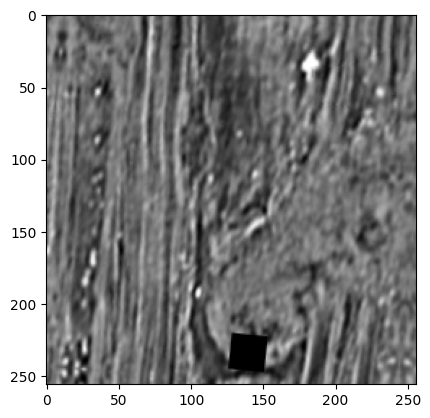

In [13]:
img_2 = img.squeeze(0).permute(1, 2, 0).numpy()
plt.imshow(img_2[:, :, 0], cmap="gray")

### Model
* Encoder is a 3D ResNet model. The architecture has been modified to remove temporal downsampling between blocks.
* A 2D decoder is used for predicting the segmentation map.
* The encoder feature maps are average pooled over the Z dimension before passing it to the decoder.

In [14]:
class Decoder(nn.Module):
    def __init__(self, encoder_dims, upscale):
        super().__init__()
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(encoder_dims[i]+encoder_dims[i-1], encoder_dims[i-1], 3, 1, 1, bias=False),
                nn.BatchNorm2d(encoder_dims[i-1]),
                nn.ReLU(inplace=True)
            ) for i in range(1, len(encoder_dims))])

        self.logit = nn.Conv2d(encoder_dims[0], 1, 1, 1, 0)
        self.up = nn.Upsample(scale_factor=upscale, mode="bilinear")

    def forward(self, feature_maps):
        for i in range(len(feature_maps)-1, 0, -1):
            f_up = F.interpolate(feature_maps[i], scale_factor=2, mode="bilinear")
            f = torch.cat([feature_maps[i-1], f_up], dim=1)
            f_down = self.convs[i-1](f)
            feature_maps[i-1] = f_down

        x = self.logit(feature_maps[0])
        mask = self.up(x)
        return mask


class SegModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = generate_model(model_depth=18, n_input_channels=1)
        self.decoder = Decoder(encoder_dims=[64, 128, 256, 512], upscale=4)
        
    def forward(self, x):
        feat_maps = self.encoder(x)
        feat_maps_pooled = [torch.mean(f, dim=2) for f in feat_maps]
        pred_mask = self.decoder(feat_maps_pooled)
        return pred_mask
    
    def load_pretrained_weights(self, state_dict):
        # Convert 3 channel weights to single channel
        # ref - https://timm.fast.ai/models#Case-1:-When-the-number-of-input-channels-is-1
        conv1_weight = state_dict['conv1.weight']
        state_dict['conv1.weight'] = conv1_weight.sum(dim=1, keepdim=True)
        print(self.encoder.load_state_dict(state_dict, strict=False))

In [15]:
model = SegModel()
model.load_pretrained_weights(torch.load("/home/viktor/Documents/kaggle/vesuvius-challenge/experiments/3D-resnet/r3d18_K_200ep.pth")["state_dict"])
model = nn.DataParallel(model, device_ids=[0])

model = model.cuda()

_IncompatibleKeys(missing_keys=[], unexpected_keys=['fc.weight', 'fc.bias'])


In [16]:
x = torch.randn(5, 1, 16, 256, 256).cuda()
with torch.no_grad():
    y = model(x)
y.shape

torch.Size([5, 1, 256, 256])

### Competition metric (F0.5 Score)

In [17]:
# ref - https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
def fbeta_score(preds, targets, threshold, beta=0.5, smooth=1e-5):
    preds_t = torch.where(preds > threshold, 1.0, 0.0).float()
    y_true_count = targets.sum()
    
    ctp = preds_t[targets==1].sum()
    cfp = preds_t[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

### Training

In [18]:
scaler = amp.GradScaler()
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR,
                                                steps_per_epoch=10, epochs=EPOCHS//10,
                                                pct_start=0.1)

In [19]:
gt_mask = torch.from_numpy(np.asarray(FRAGMENTS_ZARR[TEST_FRAGMENT].truth)).float().cuda()
gt_shape = FRAGMENTS_SHAPE[TEST_FRAGMENT]

In [20]:
import logging

logging.basicConfig(filename="training_log.txt", level=logging.INFO)


In [21]:
fbeta_best = 0.0
for epoch in range(1, EPOCHS+1):
    model.train()
    cur_lr = f"LR : {scheduler.get_last_lr()[0]:.2E}"
    pbar_train = enumerate(dataloader_train)
    pbar_train = tqdm(pbar_train, total=n_train, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
    mloss_train, mloss_val, val_metric = 0.0, 0.0, 0.0

    




    for i, (fragments, masks) in pbar_train:
        fragments, masks = fragments.cuda().half(), masks.cuda().half()
        
        
        optimizer.zero_grad()
        with amp.autocast():
            pred_masks = model(fragments)
            loss = criterion(pred_masks, masks)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            mloss_train += loss.detach().item()

        gpu_mem = f"Mem : {torch.cuda.memory_reserved() / 1E9:.3g}GB"
        pbar_train.set_description(("%10s  " * 3 + "%10s") % (f"Epoch {epoch}/{EPOCHS}", gpu_mem, cur_lr,
                                                              f"Loss: {mloss_train / (i + 1):.4f}"))
        
    scheduler.step()
    model.eval()
    pbar_val = enumerate(dataloader_valid)
    pbar_val = tqdm(pbar_val, total=n_valid, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
    final_pred_mask = torch.zeros(gt_shape, dtype=torch.float32, device='cuda')
    
    for i, (fragments, masks, xys) in pbar_val:
        fragments, masks = fragments.cuda(), masks.cuda()
        
        with torch.no_grad():
            pred_masks = model(fragments)
            mloss_val += criterion(pred_masks, masks).item()
            pred_masks = torch.sigmoid(pred_masks)
        
        for j, xy in enumerate(xys):
            final_pred_mask[xy[1]:xy[3], xy[0]:xy[2]] = pred_masks[j, 0]

        pbar_val.set_description(("%10s") % (f"Val Loss: {mloss_val / (i+1):.4f}"))
    
    for threshold in np.arange(0.2, 0.85, 0.05):
        fbeta = fbeta_score(final_pred_mask, gt_mask, threshold)
        print(f"Threshold : {threshold:.2f}\tFBeta : {fbeta:.6f}")
        
        if fbeta_best < fbeta:
            fbeta_best = fbeta
            torch.save(model.module.state_dict(), f"./ckpts/resnet18_3d_seg_best_{fbeta_best:.4f}.pt")
    
    
    if epoch >= 10:
        torch.save(model.module.state_dict(), f"./ckpts/resnet18_3d_seg_epoch_{epoch}.pt")

    # if epoch == 30:
    #     break

    print()

Epoch 1/50  Mem : 13.6GB  LR : 4.00E-06  Loss: 0.6626: 100%|██████████| 64/64 [00:38<00:00,  1.66it/s]                                                                                                                                                                           
Val Loss: 0.5695: 100%|██████████| 19/19 [00:04<00:00,  3.81it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.102598
Threshold : 0.25	FBeta : 0.105903
Threshold : 0.30	FBeta : 0.117529
Threshold : 0.35	FBeta : 0.136118
Threshold : 0.40	FBeta : 0.156496
Threshold : 0.45	FBeta : 0.176064
Threshold : 0.50	FBeta : 0.194498
Threshold : 0.55	FBeta : 0.213281
Threshold : 0.60	FBeta : 0.191171
Threshold : 0.65	FBeta : 0.074808
Threshold : 0.70	FBeta : 0.005846
Threshold : 0.75	FBeta : 0.000145
Threshold : 0.80	FBeta : 0.000000



Epoch 2/50  Mem : 18GB  LR : 1.81E-05  Loss: 0.5718: 100%|██████████| 64/64 [00:38<00:00,  1.66it/s]                                                                                                                                                                             
Val Loss: 0.4494: 100%|██████████| 19/19 [00:04<00:00,  3.81it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.142897
Threshold : 0.25	FBeta : 0.151398
Threshold : 0.30	FBeta : 0.157992
Threshold : 0.35	FBeta : 0.164983
Threshold : 0.40	FBeta : 0.179220
Threshold : 0.45	FBeta : 0.198288
Threshold : 0.50	FBeta : 0.215800
Threshold : 0.55	FBeta : 0.234938
Threshold : 0.60	FBeta : 0.115721
Threshold : 0.65	FBeta : 0.000183
Threshold : 0.70	FBeta : 0.000000
Threshold : 0.75	FBeta : 0.000000
Threshold : 0.80	FBeta : 0.000000



Epoch 3/50  Mem : 18GB  LR : 5.20E-05  Loss: 0.5116: 100%|██████████| 64/64 [00:38<00:00,  1.68it/s]                                                                                                                                                                             
Val Loss: 0.3862: 100%|██████████| 19/19 [00:05<00:00,  3.78it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.149916
Threshold : 0.25	FBeta : 0.156413
Threshold : 0.30	FBeta : 0.168626
Threshold : 0.35	FBeta : 0.206889
Threshold : 0.40	FBeta : 0.238624
Threshold : 0.45	FBeta : 0.254332
Threshold : 0.50	FBeta : 0.260697
Threshold : 0.55	FBeta : 0.253757
Threshold : 0.60	FBeta : 0.153596
Threshold : 0.65	FBeta : 0.006463
Threshold : 0.70	FBeta : 0.000000
Threshold : 0.75	FBeta : 0.000000
Threshold : 0.80	FBeta : 0.000000



Epoch 4/50  Mem : 18GB  LR : 8.59E-05  Loss: 0.4799: 100%|██████████| 64/64 [00:38<00:00,  1.68it/s]                                                                                                                                                                             
Val Loss: 0.5483: 100%|██████████| 19/19 [00:05<00:00,  3.80it/s]                                                                                                                                                                                                                

Threshold : 0.20	FBeta : 0.137978
Threshold : 0.25	FBeta : 0.150817
Threshold : 0.30	FBeta : 0.168144
Threshold : 0.35	FBeta : 0.181331
Threshold : 0.40	FBeta : 0.190874
Threshold : 0.45	FBeta : 0.196640
Threshold : 0.50	FBeta : 0.198213
Threshold : 0.55	FBeta : 0.194476
Threshold : 0.60	FBeta : 0.103581
Threshold : 0.65	FBeta : 0.004043
Threshold : 0.70	FBeta : 0.000000
Threshold : 0.75	FBeta : 0.000000
Threshold : 0.80	FBeta : 0.000000




Epoch 5/50  Mem : 18GB  LR : 1.00E-04  Loss: 0.4509: 100%|██████████| 64/64 [00:37<00:00,  1.69it/s]                                                                                                                                                                             
Val Loss: 0.3833: 100%|██████████| 19/19 [00:04<00:00,  3.80it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.163425
Threshold : 0.25	FBeta : 0.183778
Threshold : 0.30	FBeta : 0.214446
Threshold : 0.35	FBeta : 0.233848
Threshold : 0.40	FBeta : 0.250707
Threshold : 0.45	FBeta : 0.266581
Threshold : 0.50	FBeta : 0.284551
Threshold : 0.55	FBeta : 0.307628
Threshold : 0.60	FBeta : 0.327556
Threshold : 0.65	FBeta : 0.334744
Threshold : 0.70	FBeta : 0.252340
Threshold : 0.75	FBeta : 0.056756
Threshold : 0.80	FBeta : 0.005539



Epoch 6/50  Mem : 18GB  LR : 9.99E-05  Loss: 0.4260: 100%|██████████| 64/64 [00:38<00:00,  1.68it/s]                                                                                                                                                                             
Val Loss: 0.3388: 100%|██████████| 19/19 [00:05<00:00,  3.79it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.157316
Threshold : 0.25	FBeta : 0.197854
Threshold : 0.30	FBeta : 0.249834
Threshold : 0.35	FBeta : 0.281169
Threshold : 0.40	FBeta : 0.306260
Threshold : 0.45	FBeta : 0.326338
Threshold : 0.50	FBeta : 0.343446
Threshold : 0.55	FBeta : 0.352883
Threshold : 0.60	FBeta : 0.338239
Threshold : 0.65	FBeta : 0.271258
Threshold : 0.70	FBeta : 0.157452
Threshold : 0.75	FBeta : 0.038101
Threshold : 0.80	FBeta : 0.000000



Epoch 7/50  Mem : 18GB  LR : 9.95E-05  Loss: 0.4023: 100%|██████████| 64/64 [00:37<00:00,  1.69it/s]                                                                                                                                                                             
Val Loss: 0.3085: 100%|██████████| 19/19 [00:05<00:00,  3.73it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.195275
Threshold : 0.25	FBeta : 0.234389
Threshold : 0.30	FBeta : 0.269494
Threshold : 0.35	FBeta : 0.300624
Threshold : 0.40	FBeta : 0.334193
Threshold : 0.45	FBeta : 0.374840
Threshold : 0.50	FBeta : 0.414581
Threshold : 0.55	FBeta : 0.451039
Threshold : 0.60	FBeta : 0.475949
Threshold : 0.65	FBeta : 0.473339
Threshold : 0.70	FBeta : 0.416347
Threshold : 0.75	FBeta : 0.298719
Threshold : 0.80	FBeta : 0.158883



Epoch 8/50  Mem : 18GB  LR : 9.89E-05  Loss: 0.3976: 100%|██████████| 64/64 [00:38<00:00,  1.65it/s]                                                                                                                                                                             
Val Loss: 0.2472: 100%|██████████| 19/19 [00:04<00:00,  3.80it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.292713
Threshold : 0.25	FBeta : 0.390492
Threshold : 0.30	FBeta : 0.452785
Threshold : 0.35	FBeta : 0.491487
Threshold : 0.40	FBeta : 0.513174
Threshold : 0.45	FBeta : 0.514682
Threshold : 0.50	FBeta : 0.485276
Threshold : 0.55	FBeta : 0.438134
Threshold : 0.60	FBeta : 0.367494
Threshold : 0.65	FBeta : 0.281233
Threshold : 0.70	FBeta : 0.194950
Threshold : 0.75	FBeta : 0.122774
Threshold : 0.80	FBeta : 0.068639



Epoch 9/50  Mem : 18GB  LR : 9.81E-05  Loss: 0.3748: 100%|██████████| 64/64 [00:38<00:00,  1.68it/s]                                                                                                                                                                             
Val Loss: 0.2436: 100%|██████████| 19/19 [00:04<00:00,  3.82it/s]                                                                                                                                                                                                                

Threshold : 0.20	FBeta : 0.412354
Threshold : 0.25	FBeta : 0.435557
Threshold : 0.30	FBeta : 0.425621
Threshold : 0.35	FBeta : 0.397112
Threshold : 0.40	FBeta : 0.351627
Threshold : 0.45	FBeta : 0.305371
Threshold : 0.50	FBeta : 0.257247
Threshold : 0.55	FBeta : 0.206184
Threshold : 0.60	FBeta : 0.144626
Threshold : 0.65	FBeta : 0.078840
Threshold : 0.70	FBeta : 0.030922
Threshold : 0.75	FBeta : 0.009306
Threshold : 0.80	FBeta : 0.001862




Epoch 10/50  Mem : 18GB  LR : 9.70E-05  Loss: 0.3724: 100%|██████████| 64/64 [00:38<00:00,  1.66it/s]                                                                                                                                                                            
Val Loss: 0.2494: 100%|██████████| 19/19 [00:04<00:00,  3.80it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.301853
Threshold : 0.25	FBeta : 0.402002
Threshold : 0.30	FBeta : 0.445503
Threshold : 0.35	FBeta : 0.459008
Threshold : 0.40	FBeta : 0.437709
Threshold : 0.45	FBeta : 0.393150
Threshold : 0.50	FBeta : 0.316526
Threshold : 0.55	FBeta : 0.234168
Threshold : 0.60	FBeta : 0.160708
Threshold : 0.65	FBeta : 0.105673
Threshold : 0.70	FBeta : 0.058965
Threshold : 0.75	FBeta : 0.029659
Threshold : 0.80	FBeta : 0.010451



Epoch 11/50  Mem : 18GB  LR : 9.57E-05  Loss: 0.3639: 100%|██████████| 64/64 [00:38<00:00,  1.68it/s]                                                                                                                                                                            
Val Loss: 0.2273: 100%|██████████| 19/19 [00:04<00:00,  3.80it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.451611
Threshold : 0.25	FBeta : 0.480946
Threshold : 0.30	FBeta : 0.492001
Threshold : 0.35	FBeta : 0.484230
Threshold : 0.40	FBeta : 0.467828
Threshold : 0.45	FBeta : 0.449236
Threshold : 0.50	FBeta : 0.426832
Threshold : 0.55	FBeta : 0.389775
Threshold : 0.60	FBeta : 0.325511
Threshold : 0.65	FBeta : 0.243239
Threshold : 0.70	FBeta : 0.164909
Threshold : 0.75	FBeta : 0.101874
Threshold : 0.80	FBeta : 0.062344



Epoch 12/50  Mem : 18GB  LR : 9.41E-05  Loss: 0.3521: 100%|██████████| 64/64 [00:37<00:00,  1.70it/s]                                                                                                                                                                            
Val Loss: 0.2252: 100%|██████████| 19/19 [00:05<00:00,  3.76it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.495948
Threshold : 0.25	FBeta : 0.506536
Threshold : 0.30	FBeta : 0.499660
Threshold : 0.35	FBeta : 0.480581
Threshold : 0.40	FBeta : 0.451508
Threshold : 0.45	FBeta : 0.409715
Threshold : 0.50	FBeta : 0.364475
Threshold : 0.55	FBeta : 0.304821
Threshold : 0.60	FBeta : 0.238146
Threshold : 0.65	FBeta : 0.183026
Threshold : 0.70	FBeta : 0.127332
Threshold : 0.75	FBeta : 0.076794
Threshold : 0.80	FBeta : 0.036369



Epoch 13/50  Mem : 18GB  LR : 9.24E-05  Loss: 0.3403: 100%|██████████| 64/64 [00:38<00:00,  1.67it/s]                                                                                                                                                                            
Val Loss: 0.2236: 100%|██████████| 19/19 [00:05<00:00,  3.80it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.370632
Threshold : 0.25	FBeta : 0.411579
Threshold : 0.30	FBeta : 0.439264
Threshold : 0.35	FBeta : 0.460065
Threshold : 0.40	FBeta : 0.482185
Threshold : 0.45	FBeta : 0.502959
Threshold : 0.50	FBeta : 0.514942
Threshold : 0.55	FBeta : 0.520044
Threshold : 0.60	FBeta : 0.525186
Threshold : 0.65	FBeta : 0.511857
Threshold : 0.70	FBeta : 0.476989
Threshold : 0.75	FBeta : 0.427611
Threshold : 0.80	FBeta : 0.364670



Epoch 14/50  Mem : 18GB  LR : 9.05E-05  Loss: 0.3390: 100%|██████████| 64/64 [00:38<00:00,  1.65it/s]                                                                                                                                                                            
Val Loss: 0.2109: 100%|██████████| 19/19 [00:05<00:00,  3.80it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.371326
Threshold : 0.25	FBeta : 0.414847
Threshold : 0.30	FBeta : 0.448909
Threshold : 0.35	FBeta : 0.478968
Threshold : 0.40	FBeta : 0.504066
Threshold : 0.45	FBeta : 0.518692
Threshold : 0.50	FBeta : 0.521308
Threshold : 0.55	FBeta : 0.511671
Threshold : 0.60	FBeta : 0.484055
Threshold : 0.65	FBeta : 0.438038
Threshold : 0.70	FBeta : 0.378622
Threshold : 0.75	FBeta : 0.308211
Threshold : 0.80	FBeta : 0.228479



Epoch 15/50  Mem : 18GB  LR : 8.83E-05  Loss: 0.3306: 100%|██████████| 64/64 [00:38<00:00,  1.65it/s]                                                                                                                                                                            
Val Loss: 0.2203: 100%|██████████| 19/19 [00:05<00:00,  3.70it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.496345
Threshold : 0.25	FBeta : 0.507328
Threshold : 0.30	FBeta : 0.489251
Threshold : 0.35	FBeta : 0.458311
Threshold : 0.40	FBeta : 0.433520
Threshold : 0.45	FBeta : 0.403553
Threshold : 0.50	FBeta : 0.370192
Threshold : 0.55	FBeta : 0.330134
Threshold : 0.60	FBeta : 0.278999
Threshold : 0.65	FBeta : 0.227442
Threshold : 0.70	FBeta : 0.178372
Threshold : 0.75	FBeta : 0.129631
Threshold : 0.80	FBeta : 0.077234



Epoch 16/50  Mem : 18GB  LR : 8.60E-05  Loss: 0.3286: 100%|██████████| 64/64 [00:38<00:00,  1.67it/s]                                                                                                                                                                            
Val Loss: 0.2793: 100%|██████████| 19/19 [00:05<00:00,  3.79it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.223892
Threshold : 0.25	FBeta : 0.253351
Threshold : 0.30	FBeta : 0.280456
Threshold : 0.35	FBeta : 0.307474
Threshold : 0.40	FBeta : 0.335035
Threshold : 0.45	FBeta : 0.367975
Threshold : 0.50	FBeta : 0.404015
Threshold : 0.55	FBeta : 0.457812
Threshold : 0.60	FBeta : 0.497897
Threshold : 0.65	FBeta : 0.529294
Threshold : 0.70	FBeta : 0.545203
Threshold : 0.75	FBeta : 0.546947
Threshold : 0.80	FBeta : 0.527842



Epoch 17/50  Mem : 18GB  LR : 8.35E-05  Loss: 0.3203: 100%|██████████| 64/64 [00:38<00:00,  1.68it/s]                                                                                                                                                                            
Val Loss: 0.2182: 100%|██████████| 19/19 [00:04<00:00,  3.81it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.536989
Threshold : 0.25	FBeta : 0.503408
Threshold : 0.30	FBeta : 0.453642
Threshold : 0.35	FBeta : 0.392702
Threshold : 0.40	FBeta : 0.327670
Threshold : 0.45	FBeta : 0.257084
Threshold : 0.50	FBeta : 0.176666
Threshold : 0.55	FBeta : 0.092799
Threshold : 0.60	FBeta : 0.047412
Threshold : 0.65	FBeta : 0.022630
Threshold : 0.70	FBeta : 0.012525
Threshold : 0.75	FBeta : 0.006449
Threshold : 0.80	FBeta : 0.003971



Epoch 18/50  Mem : 18GB  LR : 8.08E-05  Loss: 0.3207: 100%|██████████| 64/64 [00:38<00:00,  1.66it/s]                                                                                                                                                                            
Val Loss: 0.2082: 100%|██████████| 19/19 [00:05<00:00,  3.75it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.361377
Threshold : 0.25	FBeta : 0.417638
Threshold : 0.30	FBeta : 0.460608
Threshold : 0.35	FBeta : 0.495729
Threshold : 0.40	FBeta : 0.525323
Threshold : 0.45	FBeta : 0.544699
Threshold : 0.50	FBeta : 0.545816
Threshold : 0.55	FBeta : 0.534353
Threshold : 0.60	FBeta : 0.509402
Threshold : 0.65	FBeta : 0.473742
Threshold : 0.70	FBeta : 0.425532
Threshold : 0.75	FBeta : 0.364251
Threshold : 0.80	FBeta : 0.295449



Epoch 19/50  Mem : 18GB  LR : 7.80E-05  Loss: 0.3099: 100%|██████████| 64/64 [00:37<00:00,  1.69it/s]                                                                                                                                                                            
Val Loss: 0.1873: 100%|██████████| 19/19 [00:05<00:00,  3.79it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.516980
Threshold : 0.25	FBeta : 0.548895
Threshold : 0.30	FBeta : 0.573387
Threshold : 0.35	FBeta : 0.582899
Threshold : 0.40	FBeta : 0.584989
Threshold : 0.45	FBeta : 0.583582
Threshold : 0.50	FBeta : 0.574080
Threshold : 0.55	FBeta : 0.557282
Threshold : 0.60	FBeta : 0.520530
Threshold : 0.65	FBeta : 0.467125
Threshold : 0.70	FBeta : 0.395028
Threshold : 0.75	FBeta : 0.310836
Threshold : 0.80	FBeta : 0.221287



Epoch 20/50  Mem : 18GB  LR : 7.50E-05  Loss: 0.3136: 100%|██████████| 64/64 [00:38<00:00,  1.66it/s]                                                                                                                                                                            
Val Loss: 0.1963: 100%|██████████| 19/19 [00:05<00:00,  3.75it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.529860
Threshold : 0.25	FBeta : 0.573240
Threshold : 0.30	FBeta : 0.590332
Threshold : 0.35	FBeta : 0.593575
Threshold : 0.40	FBeta : 0.586614
Threshold : 0.45	FBeta : 0.566620
Threshold : 0.50	FBeta : 0.531684
Threshold : 0.55	FBeta : 0.477844
Threshold : 0.60	FBeta : 0.422250
Threshold : 0.65	FBeta : 0.364523
Threshold : 0.70	FBeta : 0.300807
Threshold : 0.75	FBeta : 0.234803
Threshold : 0.80	FBeta : 0.168668



Epoch 21/50  Mem : 18GB  LR : 7.19E-05  Loss: 0.3109: 100%|██████████| 64/64 [00:37<00:00,  1.69it/s]                                                                                                                                                                            
Val Loss: 0.1825: 100%|██████████| 19/19 [00:05<00:00,  3.76it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.450223
Threshold : 0.25	FBeta : 0.491857
Threshold : 0.30	FBeta : 0.520705
Threshold : 0.35	FBeta : 0.543686
Threshold : 0.40	FBeta : 0.563770
Threshold : 0.45	FBeta : 0.580870
Threshold : 0.50	FBeta : 0.590722
Threshold : 0.55	FBeta : 0.587154
Threshold : 0.60	FBeta : 0.575345
Threshold : 0.65	FBeta : 0.556069
Threshold : 0.70	FBeta : 0.526719
Threshold : 0.75	FBeta : 0.484689
Threshold : 0.80	FBeta : 0.421374



Epoch 22/50  Mem : 18GB  LR : 6.87E-05  Loss: 0.3029: 100%|██████████| 64/64 [00:38<00:00,  1.68it/s]                                                                                                                                                                            
Val Loss: 0.2519: 100%|██████████| 19/19 [00:05<00:00,  3.80it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.274408
Threshold : 0.25	FBeta : 0.302457
Threshold : 0.30	FBeta : 0.328515
Threshold : 0.35	FBeta : 0.355449
Threshold : 0.40	FBeta : 0.382350
Threshold : 0.45	FBeta : 0.409859
Threshold : 0.50	FBeta : 0.440217
Threshold : 0.55	FBeta : 0.474902
Threshold : 0.60	FBeta : 0.503775
Threshold : 0.65	FBeta : 0.530848
Threshold : 0.70	FBeta : 0.547629
Threshold : 0.75	FBeta : 0.557328
Threshold : 0.80	FBeta : 0.556438



Epoch 23/50  Mem : 18GB  LR : 6.55E-05  Loss: 0.3010: 100%|██████████| 64/64 [00:37<00:00,  1.69it/s]                                                                                                                                                                            
Val Loss: 0.1951: 100%|██████████| 19/19 [00:05<00:00,  3.80it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.382414
Threshold : 0.25	FBeta : 0.424116
Threshold : 0.30	FBeta : 0.455493
Threshold : 0.35	FBeta : 0.484947
Threshold : 0.40	FBeta : 0.508917
Threshold : 0.45	FBeta : 0.535050
Threshold : 0.50	FBeta : 0.554852
Threshold : 0.55	FBeta : 0.562257
Threshold : 0.60	FBeta : 0.560757
Threshold : 0.65	FBeta : 0.549206
Threshold : 0.70	FBeta : 0.522749
Threshold : 0.75	FBeta : 0.488607
Threshold : 0.80	FBeta : 0.445479



Epoch 24/50  Mem : 18GB  LR : 6.21E-05  Loss: 0.3050: 100%|██████████| 64/64 [00:37<00:00,  1.69it/s]                                                                                                                                                                            
Val Loss: 0.2251: 100%|██████████| 19/19 [00:05<00:00,  3.77it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.304856
Threshold : 0.25	FBeta : 0.333547
Threshold : 0.30	FBeta : 0.358953
Threshold : 0.35	FBeta : 0.384006
Threshold : 0.40	FBeta : 0.411225
Threshold : 0.45	FBeta : 0.437937
Threshold : 0.50	FBeta : 0.469010
Threshold : 0.55	FBeta : 0.493895
Threshold : 0.60	FBeta : 0.515033
Threshold : 0.65	FBeta : 0.532007
Threshold : 0.70	FBeta : 0.544294
Threshold : 0.75	FBeta : 0.545044
Threshold : 0.80	FBeta : 0.525383



Epoch 25/50  Mem : 18GB  LR : 5.87E-05  Loss: 0.2957: 100%|██████████| 64/64 [00:37<00:00,  1.69it/s]                                                                                                                                                                            
Val Loss: 0.2116: 100%|██████████| 19/19 [00:05<00:00,  3.80it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.327685
Threshold : 0.25	FBeta : 0.362472
Threshold : 0.30	FBeta : 0.391661
Threshold : 0.35	FBeta : 0.419016
Threshold : 0.40	FBeta : 0.445477
Threshold : 0.45	FBeta : 0.473552
Threshold : 0.50	FBeta : 0.502094
Threshold : 0.55	FBeta : 0.528418
Threshold : 0.60	FBeta : 0.549940
Threshold : 0.65	FBeta : 0.565787
Threshold : 0.70	FBeta : 0.570428
Threshold : 0.75	FBeta : 0.552563
Threshold : 0.80	FBeta : 0.510998



Epoch 26/50  Mem : 18GB  LR : 5.52E-05  Loss: 0.2916: 100%|██████████| 64/64 [00:37<00:00,  1.68it/s]                                                                                                                                                                            
Val Loss: 0.2887: 100%|██████████| 19/19 [00:05<00:00,  3.80it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.247310
Threshold : 0.25	FBeta : 0.270091
Threshold : 0.30	FBeta : 0.292112
Threshold : 0.35	FBeta : 0.314964
Threshold : 0.40	FBeta : 0.339206
Threshold : 0.45	FBeta : 0.366154
Threshold : 0.50	FBeta : 0.399043
Threshold : 0.55	FBeta : 0.432330
Threshold : 0.60	FBeta : 0.462379
Threshold : 0.65	FBeta : 0.487226
Threshold : 0.70	FBeta : 0.509472
Threshold : 0.75	FBeta : 0.531661
Threshold : 0.80	FBeta : 0.550431



Epoch 27/50  Mem : 18GB  LR : 5.17E-05  Loss: 0.2907: 100%|██████████| 64/64 [00:37<00:00,  1.69it/s]                                                                                                                                                                            
Val Loss: 0.2489: 100%|██████████| 19/19 [00:05<00:00,  3.75it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.294060
Threshold : 0.25	FBeta : 0.325963
Threshold : 0.30	FBeta : 0.354724
Threshold : 0.35	FBeta : 0.384801
Threshold : 0.40	FBeta : 0.414797
Threshold : 0.45	FBeta : 0.442599
Threshold : 0.50	FBeta : 0.468766
Threshold : 0.55	FBeta : 0.490878
Threshold : 0.60	FBeta : 0.511383
Threshold : 0.65	FBeta : 0.531042
Threshold : 0.70	FBeta : 0.548923
Threshold : 0.75	FBeta : 0.563330
Threshold : 0.80	FBeta : 0.571789



Epoch 28/50  Mem : 18GB  LR : 4.83E-05  Loss: 0.2854: 100%|██████████| 64/64 [00:38<00:00,  1.68it/s]                                                                                                                                                                            
Val Loss: 0.1858: 100%|██████████| 19/19 [00:05<00:00,  3.79it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.453731
Threshold : 0.25	FBeta : 0.483245
Threshold : 0.30	FBeta : 0.504376
Threshold : 0.35	FBeta : 0.522810
Threshold : 0.40	FBeta : 0.538611
Threshold : 0.45	FBeta : 0.552669
Threshold : 0.50	FBeta : 0.563811
Threshold : 0.55	FBeta : 0.566135
Threshold : 0.60	FBeta : 0.560692
Threshold : 0.65	FBeta : 0.545927
Threshold : 0.70	FBeta : 0.522549
Threshold : 0.75	FBeta : 0.492110
Threshold : 0.80	FBeta : 0.446982



Epoch 29/50  Mem : 18GB  LR : 4.48E-05  Loss: 0.2853: 100%|██████████| 64/64 [00:37<00:00,  1.69it/s]                                                                                                                                                                            
Val Loss: 0.2006: 100%|██████████| 19/19 [00:04<00:00,  3.80it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.371577
Threshold : 0.25	FBeta : 0.399337
Threshold : 0.30	FBeta : 0.421955
Threshold : 0.35	FBeta : 0.443187
Threshold : 0.40	FBeta : 0.466337
Threshold : 0.45	FBeta : 0.489852
Threshold : 0.50	FBeta : 0.509847
Threshold : 0.55	FBeta : 0.528831
Threshold : 0.60	FBeta : 0.546590
Threshold : 0.65	FBeta : 0.560676
Threshold : 0.70	FBeta : 0.565595
Threshold : 0.75	FBeta : 0.556656
Threshold : 0.80	FBeta : 0.530617



Epoch 30/50  Mem : 18GB  LR : 4.13E-05  Loss: 0.2852: 100%|██████████| 64/64 [00:38<00:00,  1.67it/s]                                                                                                                                                                            
Val Loss: 0.2349: 100%|██████████| 19/19 [00:04<00:00,  3.80it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.314873
Threshold : 0.25	FBeta : 0.347876
Threshold : 0.30	FBeta : 0.378010
Threshold : 0.35	FBeta : 0.405372
Threshold : 0.40	FBeta : 0.430150
Threshold : 0.45	FBeta : 0.455489
Threshold : 0.50	FBeta : 0.482256
Threshold : 0.55	FBeta : 0.508066
Threshold : 0.60	FBeta : 0.530024
Threshold : 0.65	FBeta : 0.548259
Threshold : 0.70	FBeta : 0.566145
Threshold : 0.75	FBeta : 0.580150
Threshold : 0.80	FBeta : 0.585274



Epoch 31/50  Mem : 18GB  LR : 3.79E-05  Loss: 0.2790: 100%|██████████| 64/64 [00:38<00:00,  1.66it/s]                                                                                                                                                                            
Val Loss: 0.1735: 100%|██████████| 19/19 [00:04<00:00,  3.80it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.505902
Threshold : 0.25	FBeta : 0.542002
Threshold : 0.30	FBeta : 0.571026
Threshold : 0.35	FBeta : 0.590614
Threshold : 0.40	FBeta : 0.599126
Threshold : 0.45	FBeta : 0.601466
Threshold : 0.50	FBeta : 0.599792
Threshold : 0.55	FBeta : 0.593905
Threshold : 0.60	FBeta : 0.582653
Threshold : 0.65	FBeta : 0.559003
Threshold : 0.70	FBeta : 0.528897
Threshold : 0.75	FBeta : 0.486673
Threshold : 0.80	FBeta : 0.423575



Epoch 32/50  Mem : 18GB  LR : 3.45E-05  Loss: 0.2673: 100%|██████████| 64/64 [00:38<00:00,  1.68it/s]                                                                                                                                                                            
Val Loss: 0.1725: 100%|██████████| 19/19 [00:05<00:00,  3.77it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.461103
Threshold : 0.25	FBeta : 0.495272
Threshold : 0.30	FBeta : 0.522599
Threshold : 0.35	FBeta : 0.543510
Threshold : 0.40	FBeta : 0.563858
Threshold : 0.45	FBeta : 0.584237
Threshold : 0.50	FBeta : 0.605111
Threshold : 0.55	FBeta : 0.621265
Threshold : 0.60	FBeta : 0.625473
Threshold : 0.65	FBeta : 0.619850
Threshold : 0.70	FBeta : 0.604002
Threshold : 0.75	FBeta : 0.580550
Threshold : 0.80	FBeta : 0.545979



Epoch 33/50  Mem : 18GB  LR : 3.13E-05  Loss: 0.2725: 100%|██████████| 64/64 [00:38<00:00,  1.67it/s]                                                                                                                                                                            
Val Loss: 0.1711: 100%|██████████| 19/19 [00:05<00:00,  3.79it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.520441
Threshold : 0.25	FBeta : 0.557229
Threshold : 0.30	FBeta : 0.581659
Threshold : 0.35	FBeta : 0.595579
Threshold : 0.40	FBeta : 0.605220
Threshold : 0.45	FBeta : 0.609824
Threshold : 0.50	FBeta : 0.612122
Threshold : 0.55	FBeta : 0.607651
Threshold : 0.60	FBeta : 0.598380
Threshold : 0.65	FBeta : 0.576749
Threshold : 0.70	FBeta : 0.546199
Threshold : 0.75	FBeta : 0.504265
Threshold : 0.80	FBeta : 0.445926



Epoch 34/50  Mem : 18GB  LR : 2.81E-05  Loss: 0.2685: 100%|██████████| 64/64 [00:38<00:00,  1.67it/s]                                                                                                                                                                            
Val Loss: 0.1919: 100%|██████████| 19/19 [00:05<00:00,  3.79it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.386339
Threshold : 0.25	FBeta : 0.418632
Threshold : 0.30	FBeta : 0.446236
Threshold : 0.35	FBeta : 0.473840
Threshold : 0.40	FBeta : 0.500887
Threshold : 0.45	FBeta : 0.527840
Threshold : 0.50	FBeta : 0.556449
Threshold : 0.55	FBeta : 0.573972
Threshold : 0.60	FBeta : 0.583635
Threshold : 0.65	FBeta : 0.588319
Threshold : 0.70	FBeta : 0.590433
Threshold : 0.75	FBeta : 0.592577
Threshold : 0.80	FBeta : 0.584083



Epoch 35/50  Mem : 18GB  LR : 2.50E-05  Loss: 0.2669: 100%|██████████| 64/64 [00:38<00:00,  1.68it/s]                                                                                                                                                                            
Val Loss: 0.1855: 100%|██████████| 19/19 [00:04<00:00,  3.80it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.393687
Threshold : 0.25	FBeta : 0.427832
Threshold : 0.30	FBeta : 0.456740
Threshold : 0.35	FBeta : 0.481165
Threshold : 0.40	FBeta : 0.503345
Threshold : 0.45	FBeta : 0.527125
Threshold : 0.50	FBeta : 0.551625
Threshold : 0.55	FBeta : 0.573635
Threshold : 0.60	FBeta : 0.592051
Threshold : 0.65	FBeta : 0.605490
Threshold : 0.70	FBeta : 0.611408
Threshold : 0.75	FBeta : 0.603006
Threshold : 0.80	FBeta : 0.579430



Epoch 36/50  Mem : 18GB  LR : 2.20E-05  Loss: 0.2663: 100%|██████████| 64/64 [00:38<00:00,  1.66it/s]                                                                                                                                                                            
Val Loss: 0.1802: 100%|██████████| 19/19 [00:05<00:00,  3.80it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.428904
Threshold : 0.25	FBeta : 0.458952
Threshold : 0.30	FBeta : 0.483998
Threshold : 0.35	FBeta : 0.504440
Threshold : 0.40	FBeta : 0.523639
Threshold : 0.45	FBeta : 0.543913
Threshold : 0.50	FBeta : 0.562926
Threshold : 0.55	FBeta : 0.581995
Threshold : 0.60	FBeta : 0.594797
Threshold : 0.65	FBeta : 0.599663
Threshold : 0.70	FBeta : 0.598700
Threshold : 0.75	FBeta : 0.589902
Threshold : 0.80	FBeta : 0.573448



Epoch 37/50  Mem : 18GB  LR : 1.92E-05  Loss: 0.2605: 100%|██████████| 64/64 [00:37<00:00,  1.70it/s]                                                                                                                                                                            
Val Loss: 0.1889: 100%|██████████| 19/19 [00:04<00:00,  3.81it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.402605
Threshold : 0.25	FBeta : 0.435150
Threshold : 0.30	FBeta : 0.460757
Threshold : 0.35	FBeta : 0.484365
Threshold : 0.40	FBeta : 0.506053
Threshold : 0.45	FBeta : 0.524788
Threshold : 0.50	FBeta : 0.545228
Threshold : 0.55	FBeta : 0.566860
Threshold : 0.60	FBeta : 0.584292
Threshold : 0.65	FBeta : 0.595706
Threshold : 0.70	FBeta : 0.597270
Threshold : 0.75	FBeta : 0.591718
Threshold : 0.80	FBeta : 0.576708



Epoch 38/50  Mem : 18GB  LR : 1.65E-05  Loss: 0.2559: 100%|██████████| 64/64 [00:38<00:00,  1.68it/s]                                                                                                                                                                            
Val Loss: 0.1814: 100%|██████████| 19/19 [00:04<00:00,  3.82it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.410977
Threshold : 0.25	FBeta : 0.446369
Threshold : 0.30	FBeta : 0.475864
Threshold : 0.35	FBeta : 0.501444
Threshold : 0.40	FBeta : 0.525916
Threshold : 0.45	FBeta : 0.547190
Threshold : 0.50	FBeta : 0.566102
Threshold : 0.55	FBeta : 0.583448
Threshold : 0.60	FBeta : 0.594149
Threshold : 0.65	FBeta : 0.593084
Threshold : 0.70	FBeta : 0.586242
Threshold : 0.75	FBeta : 0.577376
Threshold : 0.80	FBeta : 0.550635



Epoch 39/50  Mem : 18GB  LR : 1.40E-05  Loss: 0.2618: 100%|██████████| 64/64 [00:38<00:00,  1.67it/s]                                                                                                                                                                            
Val Loss: 0.1790: 100%|██████████| 19/19 [00:04<00:00,  3.82it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.430904
Threshold : 0.25	FBeta : 0.462343
Threshold : 0.30	FBeta : 0.490859
Threshold : 0.35	FBeta : 0.518197
Threshold : 0.40	FBeta : 0.541648
Threshold : 0.45	FBeta : 0.559449
Threshold : 0.50	FBeta : 0.574877
Threshold : 0.55	FBeta : 0.586367
Threshold : 0.60	FBeta : 0.597664
Threshold : 0.65	FBeta : 0.602500
Threshold : 0.70	FBeta : 0.603222
Threshold : 0.75	FBeta : 0.599669
Threshold : 0.80	FBeta : 0.585298



Epoch 40/50  Mem : 18GB  LR : 1.17E-05  Loss: 0.2488: 100%|██████████| 64/64 [00:37<00:00,  1.69it/s]                                                                                                                                                                            
Val Loss: 0.1775: 100%|██████████| 19/19 [00:04<00:00,  3.81it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.446525
Threshold : 0.25	FBeta : 0.485890
Threshold : 0.30	FBeta : 0.514862
Threshold : 0.35	FBeta : 0.537600
Threshold : 0.40	FBeta : 0.557126
Threshold : 0.45	FBeta : 0.572344
Threshold : 0.50	FBeta : 0.583692
Threshold : 0.55	FBeta : 0.592473
Threshold : 0.60	FBeta : 0.592514
Threshold : 0.65	FBeta : 0.588330
Threshold : 0.70	FBeta : 0.581523
Threshold : 0.75	FBeta : 0.566661
Threshold : 0.80	FBeta : 0.540605



Epoch 41/50  Mem : 18GB  LR : 9.55E-06  Loss: 0.2438: 100%|██████████| 64/64 [00:38<00:00,  1.67it/s]                                                                                                                                                                            
Val Loss: 0.1756: 100%|██████████| 19/19 [00:04<00:00,  3.81it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.450070
Threshold : 0.25	FBeta : 0.482890
Threshold : 0.30	FBeta : 0.512074
Threshold : 0.35	FBeta : 0.536891
Threshold : 0.40	FBeta : 0.559591
Threshold : 0.45	FBeta : 0.580233
Threshold : 0.50	FBeta : 0.596903
Threshold : 0.55	FBeta : 0.608568
Threshold : 0.60	FBeta : 0.613785
Threshold : 0.65	FBeta : 0.612000
Threshold : 0.70	FBeta : 0.606935
Threshold : 0.75	FBeta : 0.594540
Threshold : 0.80	FBeta : 0.570586



Epoch 42/50  Mem : 18GB  LR : 7.60E-06  Loss: 0.2494: 100%|██████████| 64/64 [00:37<00:00,  1.71it/s]                                                                                                                                                                            
Val Loss: 0.1718: 100%|██████████| 19/19 [00:04<00:00,  3.81it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.475063
Threshold : 0.25	FBeta : 0.510977
Threshold : 0.30	FBeta : 0.539653
Threshold : 0.35	FBeta : 0.561439
Threshold : 0.40	FBeta : 0.579542
Threshold : 0.45	FBeta : 0.595641
Threshold : 0.50	FBeta : 0.607284
Threshold : 0.55	FBeta : 0.612559
Threshold : 0.60	FBeta : 0.613392
Threshold : 0.65	FBeta : 0.605917
Threshold : 0.70	FBeta : 0.594726
Threshold : 0.75	FBeta : 0.576980
Threshold : 0.80	FBeta : 0.549425



Epoch 43/50  Mem : 18GB  LR : 5.85E-06  Loss: 0.2443: 100%|██████████| 64/64 [00:38<00:00,  1.67it/s]                                                                                                                                                                            
Val Loss: 0.1741: 100%|██████████| 19/19 [00:04<00:00,  3.81it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.458241
Threshold : 0.25	FBeta : 0.491333
Threshold : 0.30	FBeta : 0.517646
Threshold : 0.35	FBeta : 0.540141
Threshold : 0.40	FBeta : 0.560429
Threshold : 0.45	FBeta : 0.576998
Threshold : 0.50	FBeta : 0.593851
Threshold : 0.55	FBeta : 0.607620
Threshold : 0.60	FBeta : 0.612673
Threshold : 0.65	FBeta : 0.612488
Threshold : 0.70	FBeta : 0.606151
Threshold : 0.75	FBeta : 0.595445
Threshold : 0.80	FBeta : 0.573150



Epoch 44/50  Mem : 18GB  LR : 4.32E-06  Loss: 0.2443: 100%|██████████| 64/64 [00:37<00:00,  1.69it/s]                                                                                                                                                                            
Val Loss: 0.1754: 100%|██████████| 19/19 [00:04<00:00,  3.81it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.459884
Threshold : 0.25	FBeta : 0.494595
Threshold : 0.30	FBeta : 0.522673
Threshold : 0.35	FBeta : 0.544979
Threshold : 0.40	FBeta : 0.564520
Threshold : 0.45	FBeta : 0.580989
Threshold : 0.50	FBeta : 0.595152
Threshold : 0.55	FBeta : 0.602381
Threshold : 0.60	FBeta : 0.605047
Threshold : 0.65	FBeta : 0.601507
Threshold : 0.70	FBeta : 0.593046
Threshold : 0.75	FBeta : 0.581407
Threshold : 0.80	FBeta : 0.565106



Epoch 45/50  Mem : 18GB  LR : 3.02E-06  Loss: 0.2498: 100%|██████████| 64/64 [00:37<00:00,  1.70it/s]                                                                                                                                                                            
Val Loss: 0.1757: 100%|██████████| 19/19 [00:04<00:00,  3.80it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.454770
Threshold : 0.25	FBeta : 0.486949
Threshold : 0.30	FBeta : 0.515313
Threshold : 0.35	FBeta : 0.538724
Threshold : 0.40	FBeta : 0.557186
Threshold : 0.45	FBeta : 0.573719
Threshold : 0.50	FBeta : 0.590985
Threshold : 0.55	FBeta : 0.605219
Threshold : 0.60	FBeta : 0.610162
Threshold : 0.65	FBeta : 0.607582
Threshold : 0.70	FBeta : 0.601098
Threshold : 0.75	FBeta : 0.588503
Threshold : 0.80	FBeta : 0.566285



Epoch 46/50  Mem : 18GB  LR : 1.94E-06  Loss: 0.2399: 100%|██████████| 64/64 [00:38<00:00,  1.68it/s]                                                                                                                                                                            
Val Loss: 0.1742: 100%|██████████| 19/19 [00:05<00:00,  3.77it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.459939
Threshold : 0.25	FBeta : 0.493302
Threshold : 0.30	FBeta : 0.519058
Threshold : 0.35	FBeta : 0.538962
Threshold : 0.40	FBeta : 0.557195
Threshold : 0.45	FBeta : 0.576963
Threshold : 0.50	FBeta : 0.593720
Threshold : 0.55	FBeta : 0.604499
Threshold : 0.60	FBeta : 0.610246
Threshold : 0.65	FBeta : 0.606961
Threshold : 0.70	FBeta : 0.598140
Threshold : 0.75	FBeta : 0.583552
Threshold : 0.80	FBeta : 0.561623



Epoch 47/50  Mem : 18GB  LR : 1.09E-06  Loss: 0.2426: 100%|██████████| 64/64 [00:38<00:00,  1.66it/s]                                                                                                                                                                            
Val Loss: 0.1789: 100%|██████████| 19/19 [00:04<00:00,  3.81it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.443296
Threshold : 0.25	FBeta : 0.474096
Threshold : 0.30	FBeta : 0.501147
Threshold : 0.35	FBeta : 0.521946
Threshold : 0.40	FBeta : 0.540903
Threshold : 0.45	FBeta : 0.558879
Threshold : 0.50	FBeta : 0.577948
Threshold : 0.55	FBeta : 0.591825
Threshold : 0.60	FBeta : 0.599485
Threshold : 0.65	FBeta : 0.600002
Threshold : 0.70	FBeta : 0.595136
Threshold : 0.75	FBeta : 0.585238
Threshold : 0.80	FBeta : 0.567243



Epoch 48/50  Mem : 18GB  LR : 4.87E-07  Loss: 0.2378: 100%|██████████| 64/64 [00:38<00:00,  1.68it/s]                                                                                                                                                                            
Val Loss: 0.1857: 100%|██████████| 19/19 [00:04<00:00,  3.82it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.426864
Threshold : 0.25	FBeta : 0.455173
Threshold : 0.30	FBeta : 0.480661
Threshold : 0.35	FBeta : 0.505282
Threshold : 0.40	FBeta : 0.525709
Threshold : 0.45	FBeta : 0.544359
Threshold : 0.50	FBeta : 0.562376
Threshold : 0.55	FBeta : 0.579328
Threshold : 0.60	FBeta : 0.593365
Threshold : 0.65	FBeta : 0.602954
Threshold : 0.70	FBeta : 0.605770
Threshold : 0.75	FBeta : 0.600903
Threshold : 0.80	FBeta : 0.589218



Epoch 49/50  Mem : 18GB  LR : 1.22E-07  Loss: 0.2417: 100%|██████████| 64/64 [00:38<00:00,  1.68it/s]                                                                                                                                                                            
Val Loss: 0.1737: 100%|██████████| 19/19 [00:04<00:00,  3.81it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.471590
Threshold : 0.25	FBeta : 0.505797
Threshold : 0.30	FBeta : 0.530703
Threshold : 0.35	FBeta : 0.550699
Threshold : 0.40	FBeta : 0.569384
Threshold : 0.45	FBeta : 0.584753
Threshold : 0.50	FBeta : 0.597901
Threshold : 0.55	FBeta : 0.604635
Threshold : 0.60	FBeta : 0.606303
Threshold : 0.65	FBeta : 0.601600
Threshold : 0.70	FBeta : 0.592601
Threshold : 0.75	FBeta : 0.579038
Threshold : 0.80	FBeta : 0.560319



Epoch 50/50  Mem : 18GB  LR : 4.00E-10  Loss: 0.2471: 100%|██████████| 64/64 [00:38<00:00,  1.68it/s]                                                                                                                                                                            
Val Loss: 0.1797: 100%|██████████| 19/19 [00:05<00:00,  3.75it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.445468
Threshold : 0.25	FBeta : 0.474750
Threshold : 0.30	FBeta : 0.503034
Threshold : 0.35	FBeta : 0.525697
Threshold : 0.40	FBeta : 0.544822
Threshold : 0.45	FBeta : 0.563140
Threshold : 0.50	FBeta : 0.580547
Threshold : 0.55	FBeta : 0.594727
Threshold : 0.60	FBeta : 0.604382
Threshold : 0.65	FBeta : 0.608209
Threshold : 0.70	FBeta : 0.603409
Threshold : 0.75	FBeta : 0.594452
Threshold : 0.80	FBeta : 0.578160



In [22]:
# import logging

# logging.basicConfig(filename="training_log.txt", level=logging.INFO)

# console = logging.StreamHandler()
# console.setLevel(logging.INFO)
# logging.getLogger('').addHandler(console)

# fbeta_best = 0.0
# for epoch in range(1, EPOCHS+1):
#     model.train()
#     cur_lr = f"LR : {scheduler.get_last_lr()[0]:.2E}"
#     pbar_train = enumerate(dataloader_train)
#     pbar_train = tqdm(pbar_train, total=n_train, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
#     mloss_train, mloss_val, val_metric = 0.0, 0.0, 0.0

#     for i, (fragments, masks) in pbar_train:
#         fragments, masks = fragments.cuda().half(), masks.cuda().half()
        
#         optimizer.zero_grad()
#         with amp.autocast():
#             pred_masks = model(fragments)
#             loss = criterion(pred_masks, masks)
#             scaler.scale(loss).backward()
#             scaler.step(optimizer)
#             scaler.update()
#             mloss_train += loss.detach().item()

#         gpu_mem = f"Mem : {torch.cuda.memory_reserved() / 1E9:.3g}GB"
#         pbar_train.set_description(("%10s  " * 3 + "%10s") % (f"Epoch {epoch}/{EPOCHS}", gpu_mem, cur_lr,
#                                                               f"Loss: {mloss_train / (i + 1):.4f}"))
#         logging.info(("%10s  " * 3 + "%10s") % (f"Epoch {epoch}/{EPOCHS}", gpu_mem, cur_lr,
#                                                 f"Loss: {mloss_train / (i + 1):.4f}"))
#     scheduler.step()
#     model.eval()
#     pbar_val = enumerate(dataloader_valid)
#     pbar_val = tqdm(pbar_val, total=n_valid, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
#     final_pred_mask = torch.zeros(gt_shape, dtype=torch.float32, device='cuda')
    
#     for i, (fragments, masks, xys) in pbar_val:
#         fragments, masks = fragments.cuda(), masks.cuda()
        
#         with torch.no_grad():
#             pred_masks = model(fragments)
#             mloss_val += criterion(pred_masks, masks).item()
#             pred_masks = torch.sigmoid(pred_masks)
        
#         for j, xy in enumerate(xys):
#             final_pred_mask[xy[1]:xy[3], xy[0]:xy[2]] = pred_masks[j, 0]

#         pbar_val.set_description(("%10s") % (f"Val Loss: {mloss_val / (i+1):.4f}"))
#         logging.info(("%10s") % (f"Val Loss: {mloss_val / (i+1):.4f}"))

#     for threshold in np.arange(0.2, 0.85, 0.05):
#         fbeta = fbeta_score(final_pred_mask, gt_mask, threshold)
#         logging.info(f"Threshold : {threshold:.2f}\tFBeta : {fbeta:.6f}")

#         if fbeta_best < fbeta:
#             fbeta_best = fbeta
#             torch.save(model.module.state_dict(), f"./ckpts/resnet18_3d_seg_best.pt")
    
#     # if epoch >= 10:
#     #     torch.save(model.module.state_dict(), f"./ckpts/resnet18_3d_seg_epoch_{epoch}.pt")
